In [2]:
###########################################################################
# Author: Christopher Thomas Goodwin
# Creation Date: 2024.05.16
# Summary: Uses sklearn to explore the data of the NSHWE Stimmungs- und Lageberichte files
#          using TF-IDF and then K-Means clustering
###########################################################################

In [3]:
#### Get all file names

from pathlib import Path

files = [] # holds file paths of all text files

for file in Path("../../data/text").glob("*.txt"):
    files.append(file.parent / file.name)

n_files = len(files)
print(n_files) # 750
print(files[0]) # should have full path

750
../../data/text/1943.02.04 - Meldungen aus dem Reich Cleaned.txt


In [4]:
#### convert all text files into strings
docs = [] # holds string version of each file (i.e. each text file converted into one string and stored here

for file in files:
    with open(file) as f:
        contents = f.read()
    docs.append(contents)
    f.close()

In [5]:
#### run TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

german_stop_words = stopwords.words('german')
additional_stop_words = ["volk", "volksgemeinschaft", "1939", "1940", "1941", "1942", "1943", "1944", "1945", "deutsch", "bevölkerung", "ii", "iii", "iv", "v", "vi", "einzelmeldungen", "volksgenossen", "sei", "seien", "worden", "meldungen", "deutsche", "deutschen", "wegen", "wurde", "gif", "pro", "kg", "minusbox", "images", "rm"]

for i in range(0, 1946):
    additional_stop_words.append(str(i))

german_stop_words.extend(additional_stop_words)

vectorizer = TfidfVectorizer(max_df=.90, min_df=5, stop_words=german_stop_words, use_idf=True, norm=None, lowercase=True, ngram_range=(1,3))
transformed_documents = vectorizer.fit_transform(docs)
transformed_documents_array = transformed_documents.toarray()
print(len(transformed_documents_array)) # should match the number above to make sure we transformed all documents

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cgoodwin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


750


In [6]:
#### output TF-IDF scores
import pandas as pd

Path("data/tf-idf_output").mkdir(parents=True, exist_ok=True) # make directory if it doesn't already exist

output_filenames = [str(file).replace(".txt", ".csv").replace("../../data/text", "data/tf-idf_output") for file in files]

for counter, doc in enumerate(transformed_documents_array):
    tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    
    one_doc_as_df.to_csv(output_filenames[counter])

In [7]:
#### Get keywords

feature_names = vectorizer.get_feature_names_out()
dense = transformed_documents.todense()
denselist = dense.tolist()

all_keywords = []

for doc in denselist:
    x = 0
    keywords = []
    for word in doc:
        if word > 0:
            keywords.append(feature_names[x])
        x += 1
    all_keywords.append(keywords)

1 : 186.39287411482528
2 : 184.9844367190886
3 : 185.47144944595024
4 : 183.10737693451088
5 : 179.83117488234382
6 : 182.42452428906566
7 : 182.52403404689886
8 : 177.97526901889267
9 : 177.7249702646641
10 : 176.86562281797117
11 : 179.14057018928085
12 : 179.32911629711205
13 : 177.90021105356868
14 : 178.19334769564463
15 : 178.4815797798389
16 : 175.15190395856885
17 : 174.72784246278917
18 : 177.02181582435503
19 : 175.69434262189083
20 : 172.2941001659219
21 : 171.71628086956358
22 : 170.96949191962614
23 : 174.60784593172815
24 : 170.42779892948874
25 : 169.30756348208513
26 : 168.557960999006
27 : 173.04878325787564
28 : 171.74804210636694
29 : 171.47114392850955
30 : 167.1675775612189
31 : 171.5929893000327
32 : 166.5921210763113
33 : 167.06471973034016
34 : 168.27861132462687
35 : 169.07600852597497
36 : 168.46941720051143
37 : 168.15097222684327
38 : 167.53190449593995
39 : 164.2051862376332
40 : 163.2679862565026
41 : 163.40892071327764
42 : 162.42699857643044
43 : 166.379

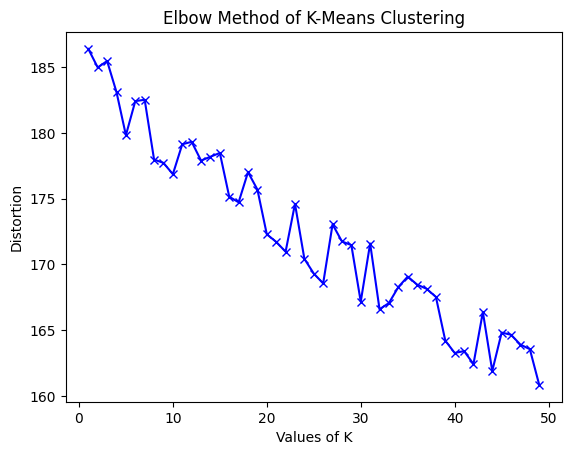

In [17]:
#### K-Means Clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 50)

for k in K:
    kmeans_test_model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1).fit(transformed_documents_array)
    
    distortions.append(sum(np.min(cdist(transformed_documents_array, kmeans_test_model.cluster_centers_, 'euclidean'), axis=1)) / transformed_documents_array.shape[0])
    
    inertias.append(kmeans_test_model.inertia_)
    
    mapping1[k] = sum(np.min(cdist(transformed_documents_array, kmeans_test_model.cluster_centers_, 'euclidean'), axis=1)) / transformed_documents_array.shape[0]
    
    mapping2[k] = kmeans_test_model.inertia_

for key, val in mapping1.items():
    print(f'{key} : {val}')
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method of K-Means Clustering')
plt.show()

In [ ]:
#### Write out the clusters based on optimal k-value
true_k = 75

kmeans_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

kmeans_model.fit(transformed_documents)

order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()

with open ("data/kmeans_output/kmeans_results.txt", 'w') as f:
    for i in range(true_k):
        f.write(f"Cluster {i}\n")
        for ind in order_centroids[i, :10]:
            f.write(f"{terms[ind]}\n")
        f.write("\n")
        f.write("\n")